In [2]:
# Essentials
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm
import matplotlib.ticker as ticker
from matplotlib import patches
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import gaussian_kde
import physoce
from physoce import oceans as oc


[Markdown Guide](https://www.markdownguide.org/cheat-sheet/)

### ADV Data to get wave height and period

In [5]:
# ADV spectra
eps1 = xr.open_dataset("/Users/jessicafranks/grad_school/grad_thesis/thesis-python/dispersal-model/ADV-data/eps1_final.nc")


Below calcualtions are from Logan's Kelp-Forest-Hydrodynamics github repository
Data_overview.ipynb

In [7]:
#Calculate wave height and period using moment integrals from Jones and Monosmith (2007)
epsDS1 = eps1.copy(deep=True)
wavetailCutoff = epsDS1.WavetailEnd.values
H = -epsDS1.Z.values
Hrms_arr = np.zeros(len(epsDS1.BurstCounter))
Hs_arr = np.zeros(len(epsDS1.BurstCounter))
Tavg_arr = np.zeros(len(epsDS1.BurstCounter))
waveOrbital_arr = np.zeros(len(epsDS1.BurstCounter))
waveAdvect_arr = np.zeros(len(epsDS1.BurstCounter))

for i in enumerate(epsDS1.BurstCounter.values):
    Snn = epsDS1.Snn[i[0]][1:wavetailCutoff[i[0]]+1].values
    omega = epsDS1.omega[1:wavetailCutoff[i[0]]+1].values
    if wavetailCutoff[i[0]] >= 25:
        Snn = epsDS1.Snn[i[0]][1:23].values
        omega = epsDS1.omega[1:23].values
    m0 = np.trapz((omega**0)*Snn, omega)
    m2 = np.trapz((omega**2)*Snn, omega)

    Hrms_arr[i[0]] = 2*np.sqrt(2*m0) #Root mean square wave height
    Hs_arr[i[0]] = 4 * np.sqrt(m0)   #Significant wave height
    Tavg_arr[i[0]] = (2*np.pi) * np.sqrt(m0/m2) #Average wave period
    waveOrbital_arr[i[0]] = oc.ubwave(Hs_arr[i[0]], Tavg_arr[i[0]], H[i[0]]) #Estimate wave orbital velocity at depth "H"
    
    #U = epsDS.WaveOrbitalVel.values[i[0]]
    omega_t = (2*np.pi)/Tavg_arr[i[0]]
    t = np.linspace(0,Tavg_arr[i[0]],100)
    d = -(waveOrbital_arr[i[0]])*np.cos(omega_t*t)+waveOrbital_arr[i[0]]
    waveAdvect_arr[i[0]] = np.trapz(d,t)/2
    
epsDS1["Hrms"] = (["time_start"], Hrms_arr,{'Description':'Root mean square wave height','Units':'m'})
epsDS1["Hs"] = (["time_start"], Hs_arr,{'Description':'Significant wave height','Units':'m'})
epsDS1["Tavg"] = (["time_start"], Tavg_arr,{'Description':'Average wave period','Units':'s'})
epsDS1["WaveOrbitalVel"] = (["time_start"], waveOrbital_arr,{'Description':'Wave orbital velocity estimate','Units':'[m/s]'})
epsDS1["WaveOrbitalAdvec"] = (["time_start"], waveAdvect_arr,{'Description':'Estimate advection distance of wave orbital','Units':'m'})

### Load the ADCP data and quality control --> only use flag 1 data.

In [9]:
# Load ADCP dataset
adcp1 = xr.open_dataset("/Users/jessicafranks/grad_school/grad_thesis/thesis-python/dispersal-model/ADCP-data/grady-adcp/adcp1_final.nc")

# Apply quality control: Flag == 1
adcp1_qc = adcp1.where(adcp1.Flag == 1)

#### Inspect binned distance

In [11]:
adcp1_qc

<xarray.Dataset>
Dimensions:         (time: 28801, bindist: 47)
Coordinates:
  * bindist         (bindist) float64 1.25 1.5 1.75 2.0 ... 12.25 12.5 12.75
  * time            (time) datetime64[ns] 2022-07-22 ... 2022-08-11
Data variables: (12/26)
    Pitch           (time, bindist) float64 0.35 0.35 0.35 0.35 ... nan nan nan
    Roll            (time, bindist) float64 0.35 0.35 0.35 0.35 ... nan nan nan
    Heading         (time, bindist) float64 87.99 87.99 87.99 ... nan nan nan
    Temperature     (time, bindist) float64 10.92 10.92 10.92 ... nan nan nan
    Depth           (time, bindist) float64 10.21 10.21 10.21 ... nan nan nan
    Battery         (time, bindist) float64 170.0 170.0 170.0 ... nan nan nan
    ...              ...
    Flag            (bindist, time) float64 1.0 1.0 1.0 1.0 ... nan nan nan nan
    EastDA          (time, bindist) float64 -0.0002 -0.0002 -0.0002 ... nan nan
    NorthDA         (time, bindist) float64 0.00116 0.00116 0.00116 ... nan nan
    VerticalDA      (time, bindist) float64 -0.00252 -0.00252 ... nan nan
    PrimaryDA       (time, bindist) float64 0.0008349 0.0008349 ... nan nan
    SecondaryDA     (time, bindist) float64 -0.0008298 -0.0008298 ... nan nan
Attributes: (12/16)
    PingsPerEns:                    70
    TimePerPing:                    00:00.85
    First Ensemble Date:            22/07/21
    First Ensemble Time:            10:30:00.00
    Ensemble Interval:              60.0
    Instrument Height:              0.44
    ...                             ...
    Description:                    First deployment of ADCP in Stillwater Cove
    Latitude:                       36.56194210195769
    Longitude:                      -121.94175918358738
    Creator:                        Logan Grady
    Contact information:            logan.grady@sjsu.edu
    Principle Axes rotation angle:  -144.95803237107697

### Reynold's number calculations

In [13]:
kv = 1.22e-6 # m^2/s^-1 this is the kinematic velocity of seawater (Grady 2024)
diameter = 0.3 #meters
# Grady 2024
max_current = 0.025 # m/s
min_current = 0.007 # m/s
re = (max_current * diameter) / kv # to be calculated later once I get diameter values for stephy in the field 

### Dispersal model setup

In [15]:
n_particles = 20
release_height = 0.3 #meters
plant_depth = 12.75 #meters
sinking_speeds = [0.0009020192] # m/s
bottom_roughness = 0.08 #meters
#Kz = 1e-4 #m^2/s
dt = 60 #seconds
settle_fraction = 0.9
kappa = 0.41

#wave_height = 0.23 # meters (grady 2024)
#wave_period = 7.4 #second (grady 2024)
g = 9.81
# U_s = (np.pi * wave_height**2) / (2 * wave_period * np.sinh(k * plant_depth)**2)

def stokes_drift(z, H, T):
    """Calculate Stokes drift at depth z given wave height H and wave period T."""
    def dispersion_relation(k):
        return g * k * np.tanh(k * plant_depth) - (2 * np.pi / T)**2
    from scipy.optimize import fsolve
    k_initial = 2 * np.pi / (g * T**2 / (2 * np.pi))  # initial guess
    k = fsolve(dispersion_relation, k_initial)[0]
    
    numerator = k * np.cosh(2 * k * (z + plant_depth))
    denominator = np.sinh(k * plant_depth)**2
    return (np.pi * H**2) / (2 * T) * numerator / denominator

In [16]:
def drag_coefficient(z, z0=0.08):
    """Compute drag coefficient CD using log-layer formulation."""
    kappa = 0.41
    return (kappa / np.log(z/z0))**2 if z > z0 else 0

def calculate_length_scales(H, T, u_star_c, u_star_w):
    """
    Calculate mixing length scales l_c and l_w.
    
    Parameters:
    - H: total water depth (m)
    - T: wave period (s)
    - u_star_c: friction velocity from currents (m/s)
    - u_star_w: friction velocity from waves (m/s)
    
    Returns:
    - l_c: mixing length scale from current (m)
    - l_w: mixing length scale from waves (m)
    """
    g = 9.81
    # Calculate wavelength L (using linear wave theory)
    # deep water wavelength approximation
    L0 = g * T**2 / (2 * np.pi)

    # If depth is shallow, use wave dispersion relation with tanh(kH)
    # Iteratively solve for k (wavenumber)
    def dispersion_relation(k):
        return g * k * np.tanh(k * H) - (2 * np.pi / T)**2

    from scipy.optimize import fsolve
    k_initial_guess = 2 * np.pi / L0
    k_solution = fsolve(dispersion_relation, k_initial_guess)[0]

    # wavelength
    L = 2 * np.pi / k_solution

    # Combined friction velocity from current and wave
    u_star_cw = np.sqrt(u_star_c**2 + u_star_w**2)

    omega = 2 * np.pi / T
    if omega == 0 or u_star_cw == 0:
        lw = 1e-6 # just a small positive default to avoid dividing by 0
    else:
        # Wave mixing length scale
        lw = 2 * k_solution * u_star_cw / omega

    # Current mixing length scale (shallow water assumption)
    lc = H / 2

    return lc, lw

In [17]:
def friction_factor(u_b, rho=1025, z=1.0, z0=0.08):
    """Estimate bottom shear stress and shear velocity."""
    CD = drag_coefficient(z, z0)
    tau_b = rho * CD * u_b**2 #bottom shear stress from currents
    u_star_c = np.sqrt(tau_b / rho)
    return tau_b, u_star_c
    
def diffusivity_Kz(z, u_b, u_wave, lc, lw, rho=1025, kappa=0.41, z0=0.08):
    """
    Calculate depth-dependent vertical turbulent diffusivity Kz at depth z.
    
    Parameters:
    - z: particle depth
    - u_b: near-bottom current velocity
    - u_wave: wave orbital velocity
    - rho: water density
    - lc: mixing length scale from currents
    - lw: mixing length scale from waves
    - kappa: turbulent mixing coefficient
    - z0: bottom roughness length
    """
    # Current shear stress and velocity
    tau_b, u_star_c = friction_factor(u_b, rho=rho, z=z, z0=z0)

    # Wave shear stress and velocity
    f_w = 2 * (u_wave / u_b)**2 if u_b > 0 else 0
    tau_w = 0.5 * rho * f_w * u_wave**2
    u_star_w = np.sqrt(tau_w / rho)

    # Turbulent kinetic energy terms (depth-dependent)
    term_current = u_star_c**2 * np.exp(-2 * z / lc)
    term_wave = u_star_w**2 * np.exp(-2 * z / lw)

    return kappa * np.sqrt(term_current + term_wave)


In [18]:
# Load ADCP and prepare interpolation
ds = xr.open_dataset("/Users/jessicafranks/grad_school/grad_thesis/thesis-python/dispersal-model/ADCP-data/grady-adcp/adcp1_final.nc")

valid = ds.Flag == 1
east = ds.East.where(valid)
north = ds.North.where(valid)

bindist = ds.bindist.values
time = ds.time.values
time_sec = (time - time[0]) / np.timedelta64(1, 's')
adcp_duration_sec = time_sec[-1] # total duration of ADCP data in seconds

u_data = east.transpose("time", "bindist").values
v_data = north.transpose("time", "bindist").values

u_interp = RegularGridInterpolator((time_sec, bindist), u_data, bounds_error=False, fill_value=0)
v_interp = RegularGridInterpolator((time_sec, bindist), v_data, bounds_error=False, fill_value=0)


In [19]:
def u_interp_extended(t, z):
    z_max = bindist.max()
    if z > z_max:
        return u_interp((t, z_max))
    else:
        return u_interp((t, z))

def v_interp_extended(t, z):
    z_max = bindist.max()
    if z > z_max:
        return v_interp((t, z_max))
    else:
        return v_interp((t, z))

In [20]:
# Propagule definitions
class Particle:
    def __init__(self, z=release_height):
        self.x = 0.0
        self.y = 0.0
        self.z = z
        self.settled = False
        self.settle_time = None

In [21]:
# Run simulation Function
def run_simulation(release_height, plant_depth, sinking_speeds,
                  Kz_mode='depth-dependent', Kz_constant=1e-4):
    particles = [Particle(z=release_height) for _ in range(n_particles)]
    positions = []
    t = 0
    settled_count = 0

    #run for 50 days instead of full ADCP time (based on zygote viability)
    max_simulation_time_sec = 2 * 24 * 60 * 60 # 50 days in seconds
    max_time_steps = int(max_simulation_time_sec / dt)
    
    while settled_count < settle_fraction * n_particles and t < max_time_steps:
        t_sec = (t * dt) % adcp_duration_sec  # loop the ADCP data
        settled_count = 0
        current_positions = []

        # === Precompute wave + shear values at current time step === #
        t_index = int((t_sec / adcp_duration_sec) * len(epsDS1.time_start))
        H_now = epsDS1.Hs.values[t_index]
        T_now = epsDS1.Tavg.values[t_index]
        u_wave_orbital = waveOrbital_arr[t_index]

        # Near-bottom current velocity (bindist.min() is lowest ADCP bin)
        u_b = u_interp((t_sec, bindist.min()))

        # Avoid divide-by-zero
        if u_b > 0:
            f_w = 2 * (u_wave_orbital / u_b)**2
        else:
            f_w = 0

        rho = 1025
        tau_w = 0.5 * rho * f_w * u_wave_orbital**2
        u_star_w = np.sqrt(tau_w / rho)

        # Bottom shear stress from current
        tau_b, u_star_c = friction_factor(u_b, rho=rho, z=1.0, z0=bottom_roughness)

        # Length scales from both wave and current
        lc, lw = calculate_length_scales(plant_depth, T_now, u_star_c, u_star_w)

        # === Now loop over particles === #
        for p in particles:
            if not p.settled:
                u = u_interp_extended(t_sec, p.z)
                v = v_interp_extended(t_sec, p.z)

                # Add stokes drift
                stokes_u = stokes_drift(p.z, H_now, T_now)
                u += stokes_u
                # Update horizontal position
                p.x += u * dt
                p.y += v * dt

                # Vertical update
                dz_sink = sinking_speeds * dt
                Kz_local = diffusivity_Kz(
                    p.z,
                    u_b=u_b,
                    u_wave=u_wave_orbital,
                    rho=rho,
                    lc=lc,
                    lw=lw,
                    kappa=kappa,
                    z0=bottom_roughness
                )
                dz_diff = np.random.normal(0, np.sqrt(2 * Kz_local * dt))

                #apply vertical changes
                p.z -= dz_sink
                p.z += dz_diff

                #== surface conditions===
                # Clamp particle depth at bottom but don't settle at the surface
                if p.z >= plant_depth:
                    p.z = plant_depth - 0.01 #just under the surface

                #== bottom conditions==
                # settle if at bobottom
                elif p.z <= bottom_roughness:
                    p.z = 0
                    p.settled = True
                    p.settle_time = t * dt
                    settled_count += 1

               # if t % 100 == 0 and p == particles[0]:  # sample one particle every 100 timesteps
                 #   print(f"t: {t*dt:.0f}s | u: {u:.3f} m/s | v: {v:.3f} m/s | Stokes: {stokes_u:.3f}")

               # if t % 100 == 0 and p == particles[0]: #track one particle's drift
                   # print(f"t={t*dt}s | x={p.x:.1f} m | y={p.y:.1f} m | z={p.z:.1f} m")

            current_positions.append((p.x, p.y, p.z))

        positions.append(current_positions)
        t += 1

    #settling times and final positions
    settling_times = []
    final_positions = []
    settled_flags = []

    for p in particles:
        final_positions.append((p.x, p.y, p.z))
        if p.settled:
            settling_times.append(p.settle_time / 3600 ) #convert to hours
            settled_flags.append(True)
        else:
            settling_times.append(None)
            settled_flags.append(False)

    return (
        np.array(final_positions), 
        np.array(settling_times), # in hours
        np.array(settled_flags)
    )
    #return np.array(positions[-1]) if positions else np.array([])

In [76]:
# Run simulations
release_heights = np.arange(0.3, 12.0, 0.05) #from 30 cm to just below 12m, every 5 cm
plant_depths = [12.0]
sinking_speeds = [0.0009020192] # m / s

settling_records = [] #stores release_height, settling_time
all_final_positions = []
results = {} #use dictionary here, not list

#to run with a constant diffusivity 
# run_simulation(r, plant_depth, sinking_speeds, Kz_mode='constant', Kz_constant=1e-3)

for r in release_heights:
    for pd_val in plant_depths:
        for ss in sinking_speeds:
            label = f"r{r}_pd{pd_val}"
           
            final_positions, settling_times, settled_flags = run_simulation(
                release_height=r,
                plant_depth=pd_val,
                sinking_speeds=ss
            )

            results[label] = (final_positions, settling_times, settled_flags)


            if len(final_positions) > 0:
                release_column = np.full((final_positions.shape[0], 1), r)
                final_with_release = np.hstack((final_positions, release_column))
                all_final_positions.append(final_with_release)

                # Add settling records
                for i, pos in enumerate(final_positions):
                    if not np.any(np.isnan(pos)):
                        release_column = np.array([[r]])
                        final_with_release = np.hstack((pos.reshape(1, -1), release_column))
                        all_final_positions.append(final_with_release)

                        if settled_flags[i]:
                            settling_records.append((r, settling_times[i]))


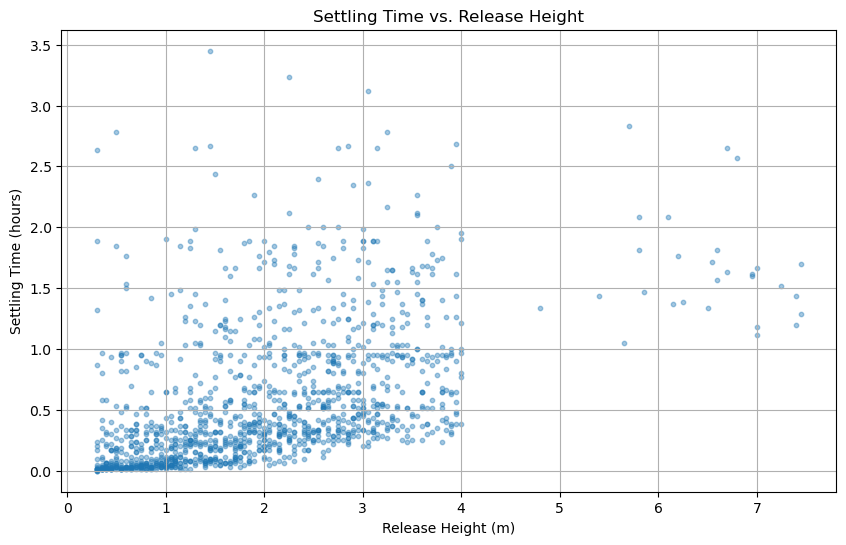

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame
df_settle = pd.DataFrame(settling_records, columns=['release_height', 'settling_time_hours'])

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_settle['release_height'], df_settle['settling_time_hours'], s=10, alpha=0.4)
plt.xlabel("Release Height (m)")
plt.ylabel("Settling Time (hours)")
plt.title("Settling Time vs. Release Height")
plt.grid(True)
plt.savefig("figures/settling_time_vs_release_height.png", dpi=300, bbox_inches='tight')
plt.show()


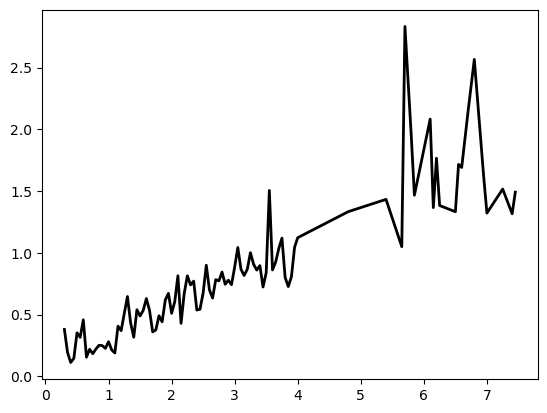

In [24]:
means = df_settle.groupby('release_height')['settling_time_hours'].mean()
plt.plot(means.index, means.values, color='black', lw=2)

In [25]:
all_final_positions = np.vstack(all_final_positions)
x, y, z, release_h = all_final_positions[:, 0], all_final_positions[:, 1], all_final_positions[:, 2], all_final_positions[:, 3]

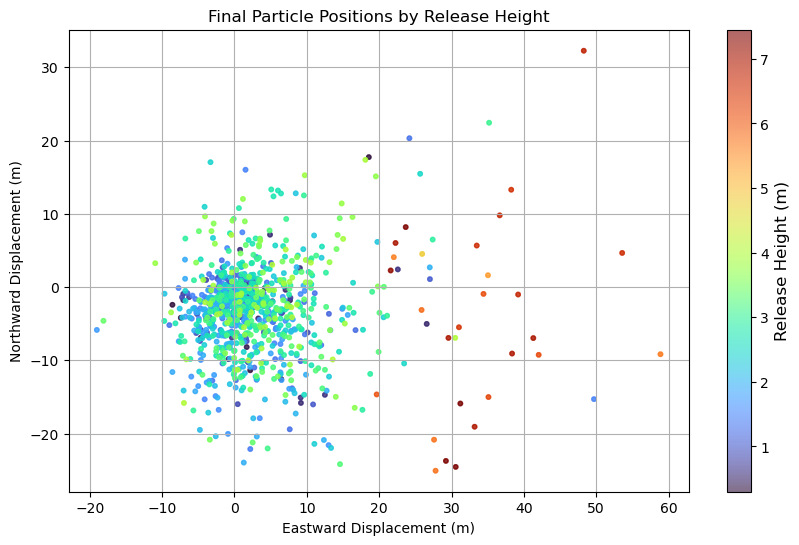

In [26]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=release_h, cmap='turbo', s=10, alpha=0.6)  # 'turbo' or 'viridis' are good for heatmaps
cbar = plt.colorbar(scatter)
cbar.set_label("Release Height (m)", fontsize=12)

plt.xlabel("Eastward Displacement (m)")
plt.ylabel("Northward Displacement (m)")
plt.title("Final Particle Positions by Release Height")
plt.grid(True)
plt.savefig("figures/displacementVSrelease-grady.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()


### lets do x vs y

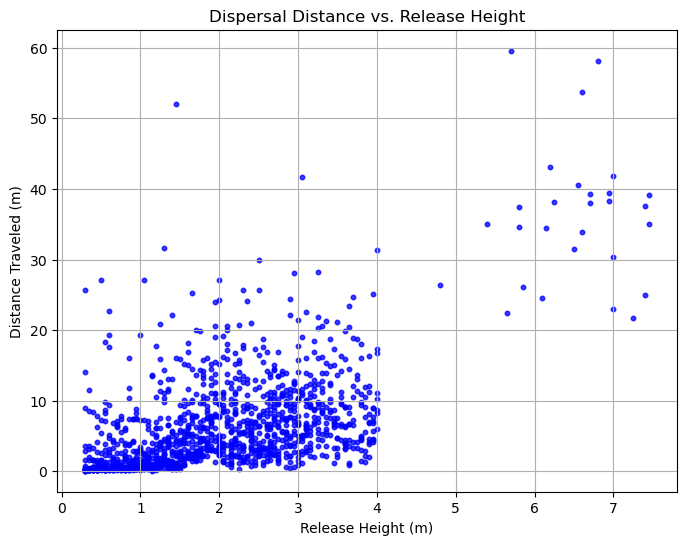

In [28]:
distance = np.sqrt(x**2 + y**2)

plt.figure(figsize=(8, 6))
plt.scatter(release_h, distance, alpha=0.5, s=10, c='blue')  # Optional: use c=distance, cmap='viridis' for gradient

plt.xlabel("Release Height (m)")
plt.ylabel("Distance Traveled (m)")
plt.title("Dispersal Distance vs. Release Height")
plt.grid(True)
plt.savefig("figures/dispersaldistVSreleaseheight-grady.png", dpi=300, bbox_inches='tight')  # Save to current working dir
plt.show()

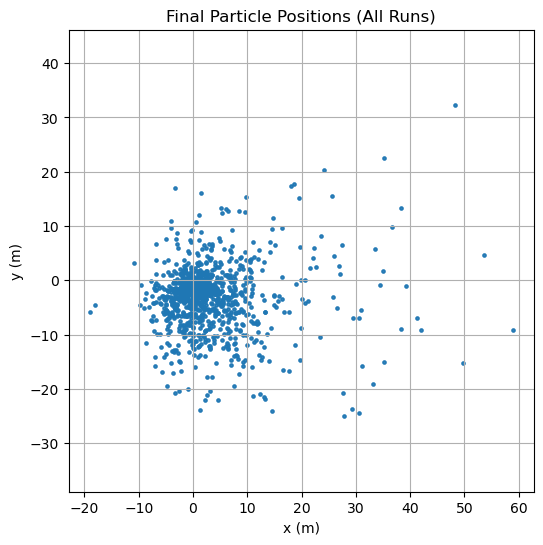

In [29]:
all_data = np.vstack(all_final_positions)  # shape: (N_particles, 4), columns: x, y, z, release_height
x_vals = all_data[:, 0]
y_vals = all_data[:, 1]

plt.figure(figsize=(6,6))
plt.scatter(x_vals, y_vals, s=5, alpha=0.7)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Final Particle Positions (All Runs)')
plt.grid(True)
plt.axis('equal')
plt.show()

In [30]:
fp, st, settled_flags = run_simulation(
    release_height=1.0,  # example value
    plant_depth=12.0,
    sinking_speeds=0.0009
)

print("Final positions shape:", fp.shape)
print("First few positions:\n", fp[:5])
print("Settling times (hours):", st[:5])

Final positions shape: (20, 3)
First few positions:
 [[ 0.35907678  0.          0.        ]
 [ 0.72521024  0.          0.        ]
 [-1.96287862 -0.18933993  0.        ]
 [ 0.60637045  0.          0.        ]
 [ 2.02335673 -1.07423647  0.        ]]
Settling times (hours): [0.03333333 0.08333333 0.41666667 0.06666667 0.35      ]


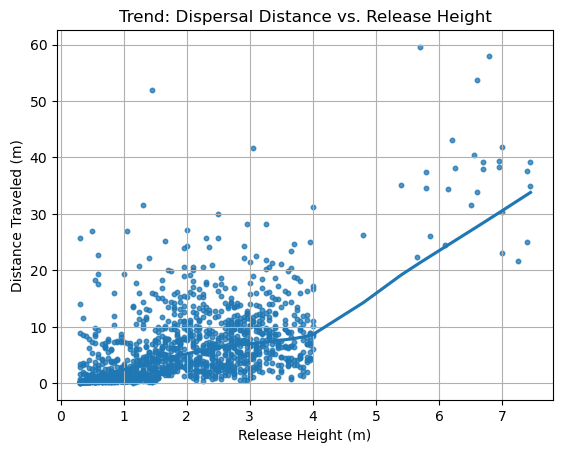

In [31]:
import seaborn as sns

sns.regplot(x=release_h, y=distance, scatter_kws={'s':10, 'alpha':0.5}, lowess=True)
plt.xlabel("Release Height (m)")
plt.ylabel("Distance Traveled (m)")
plt.title("Trend: Dispersal Distance vs. Release Height")
plt.grid(True)
plt.savefig("figures/all_releaseVSdistance-grady.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

In [32]:
import pandas as pd

df = pd.DataFrame({
    'ReleaseHeight': release_h,
    'Distance': distance
})

In [33]:
summary_df = df.groupby('ReleaseHeight').agg(
    mean_distance=('Distance', 'mean'),
    se_distance=('Distance', lambda x: x.std(ddof=1) / (len(x)**0.5))
).reset_index()


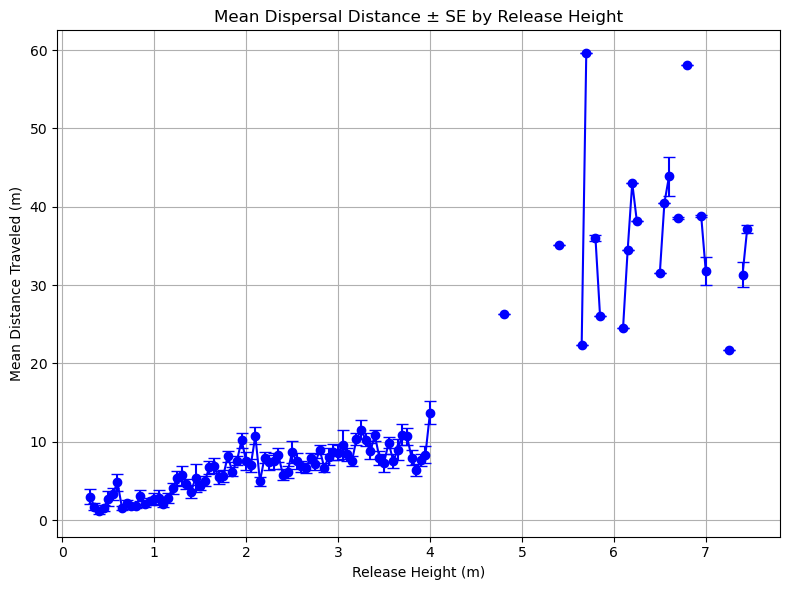

In [34]:
plt.figure(figsize=(8, 6))
plt.errorbar(
    summary_df['ReleaseHeight'],
    summary_df['mean_distance'],
    yerr=summary_df['se_distance'],
    fmt='-o',
    capsize=4,
    color='blue'
)

plt.xlabel("Release Height (m)")
plt.ylabel("Mean Distance Traveled (m)")
plt.title("Mean Dispersal Distance ± SE by Release Height")
plt.grid(True)
plt.tight_layout()
plt.show()

r0.3_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.35_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.39999999999999997_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.44999999999999996_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.49999999999999994_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.5499999999999999_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.5999999999999999_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.6499999999999999_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.7_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.7499999999999999_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.7999999999999998_pd12.0: final_positions.shape = (20, 3), settled_flags length = 20
r0.8499999999999999_pd12.0: final_positions.shape = (20, 3), settled_flags length = 

/var/folders/t6/9mj5h_qd17d697_8bs8tsr2c0000gn/T/ipykernel_25333/3913969353.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_label, group) in enumerate(df_particles.groupby('release_bin', sort=False)):


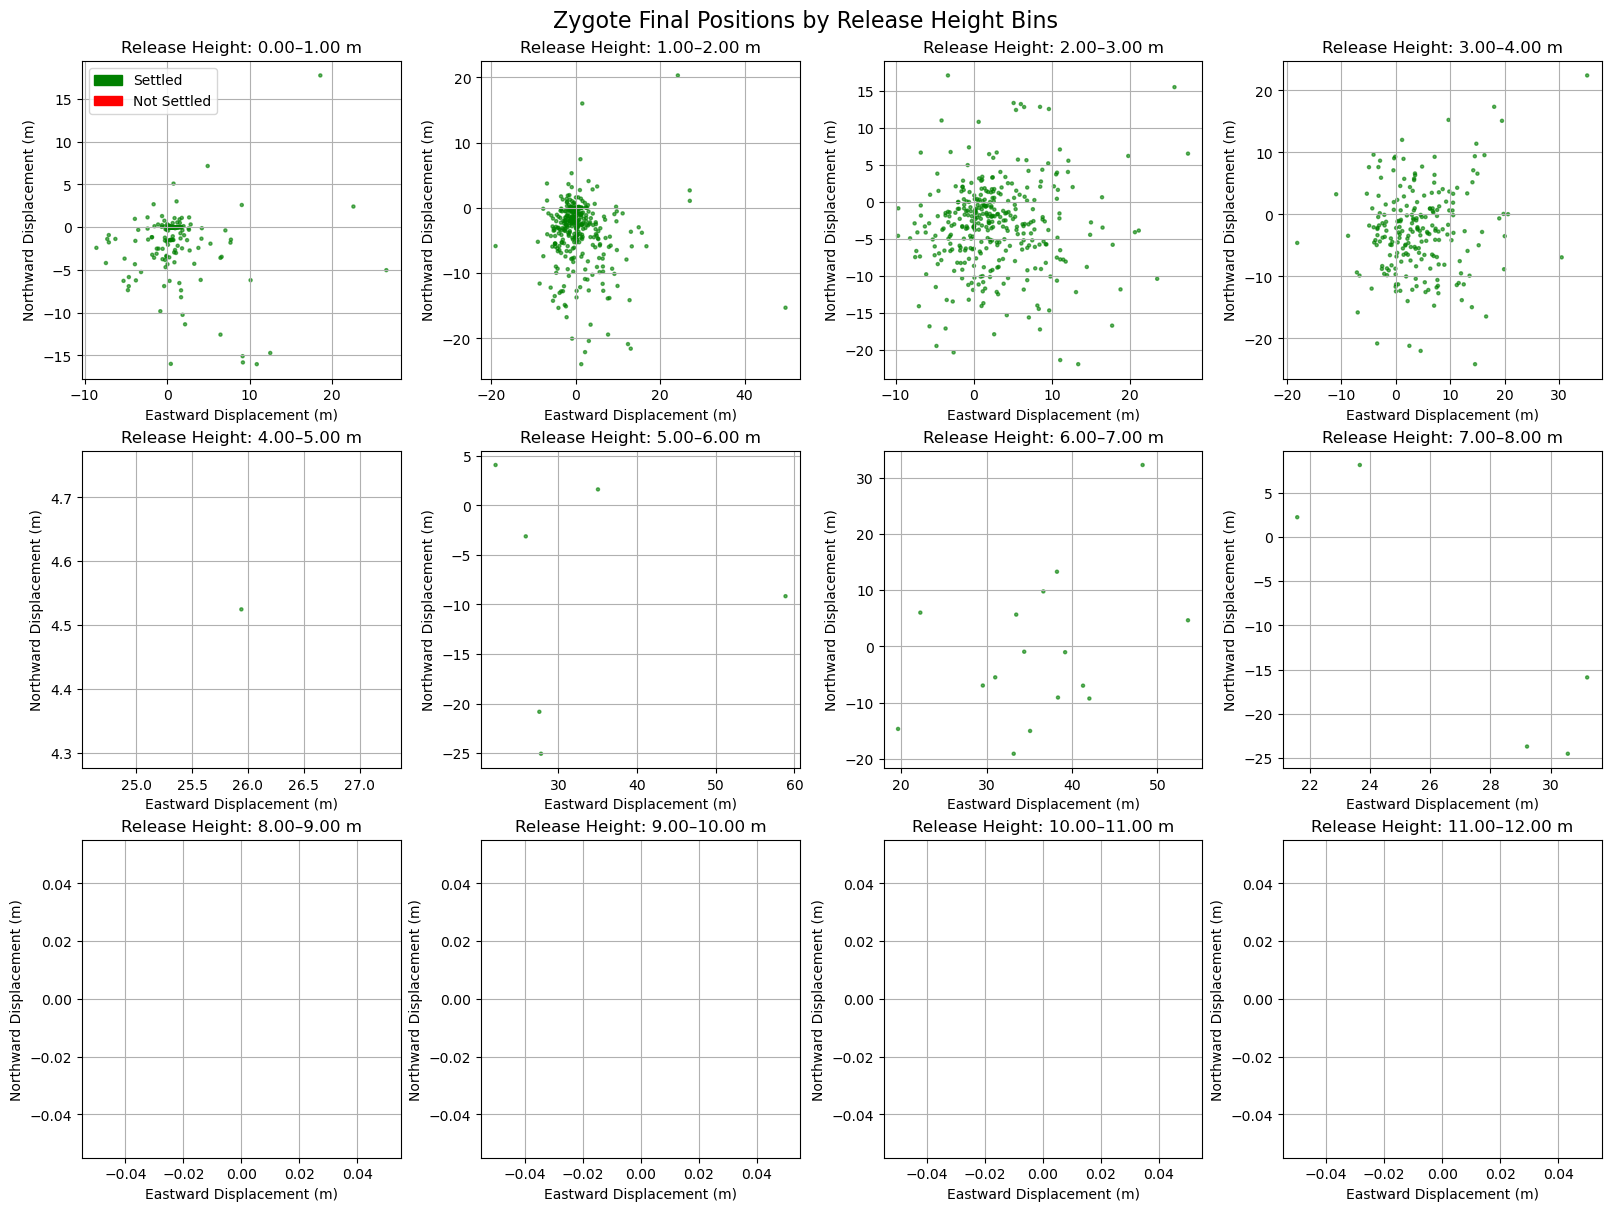

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Rebuild final positions and release height labels
all_final_positions = []
release_heights_list = []
settled_list = []

for r in release_heights:
    for pd_val in plant_depths:
        label = f"r{r}_pd{pd_val}"
        data = results.get(label)
        if data is None:
            continue

        #sanity check
        if not isinstance(data, tuple) or len(data) !=3:
            print(f"Skipping {label} - Unexpected format: {type(data)} with length {len(data) if hasattr(data, '__len__') else 'N/A'}")
            continue
            
        final_positions, settling_times, settled_flags = data

        print(f"{label}: final_positions.shape = {final_positions.shape}, settled_flags length = {len(settled_flags)}")
        
        #results[label] = (final_positions, settling_times, settled_flags)
        if final_positions.size == 0:
            print(f"Skipping {label} - no final positions")
            continue
            
        all_final_positions.append(final_positions)
        release_heights_list.extend([r] * final_positions.shape[0])
        settled_list.extend(settled_flags.tolist())

       # # Ensure it's a tuple of exactly 2 elements
       # if isinstance(data, tuple) and len(data) == 2:
        #    final_positions, settling_times = data

       #     if isinstance(final_positions, np.ndarray) and final_positions.size > 0:
       #         all_final_positions.append(final_positions)
       #         release_heights_list.extend([r] * final_positions.shape[0])
       # else:
       #     print(f"Skipping {label} — unexpected data format or empty.")

# Stack everything together
#if not all_final_positions:
#    raise ValueError("No valid final positions found. Check simulation output.")

all_final_positions = np.vstack(all_final_positions)
release_heights_array = np.array(release_heights_list)
settled_arr = np.array(settled_list)

# Build DataFrame
df_particles = pd.DataFrame({
    'x': all_final_positions[:, 0],
    'y': all_final_positions[:, 1],
    'release_height': release_heights_array,
    'settled': settled_arr
})

# Define bins (1 m increments)
start_heights = np.arange(0.0, 12.0, 1.0)
bin_ranges = [(start, start + 1) for start in start_heights]
bin_labels = [f"{low:.2f}–{high:.2f} m" for low, high in bin_ranges]

def assign_bin(height):
    for (low, high), label in zip(bin_ranges, bin_labels):
        if low <= height < high:
            return label
    return np.nan

df_particles['release_bin'] = df_particles['release_height'].apply(assign_bin)
df_particles = df_particles.dropna(subset=['release_bin'])

# Make release_bin ordered
df_particles['release_bin'] = pd.Categorical(
    df_particles['release_bin'],
    categories=bin_labels,
    ordered=True
)

color_map = {
    True: 'green',
    False: 'red'
}

# Plot layout
n_bins = len(bin_labels)
n_cols = 4
n_rows = int(np.ceil(n_bins / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Plot by bin
for i, (bin_label, group) in enumerate(df_particles.groupby('release_bin', sort=False)):
    ax = axes[i]
    settled_patch = mpatches.Patch(color='green', label='Settled')
    not_settled_patch = mpatches.Patch(color='red', label='Not Settled')
    axes[0].legend(handles=[settled_patch, not_settled_patch], loc='best')
    colors = group['settled'].map(color_map)
    ax.scatter(group['x'], group['y'], s=5, alpha=0.6, c = colors)
    ax.set_title(f"Release Height: {bin_label}")
    ax.set_xlabel("Eastward Displacement (m)")
    ax.set_ylabel("Northward Displacement (m)")
    ax.grid(True)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Zygote Final Positions by Release Height Bins", fontsize=16)
plt.savefig("figures/faceted_displacement_ordered-grady.png", dpi=300, bbox_inches='tight')
plt.show()


i don't think i need anything below this?

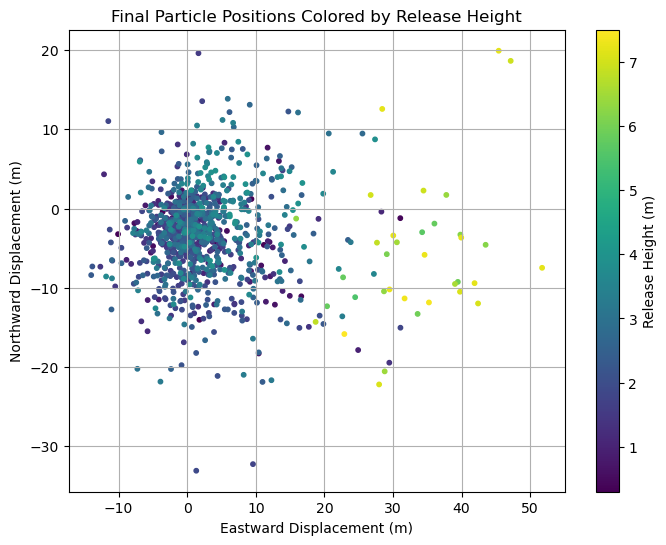

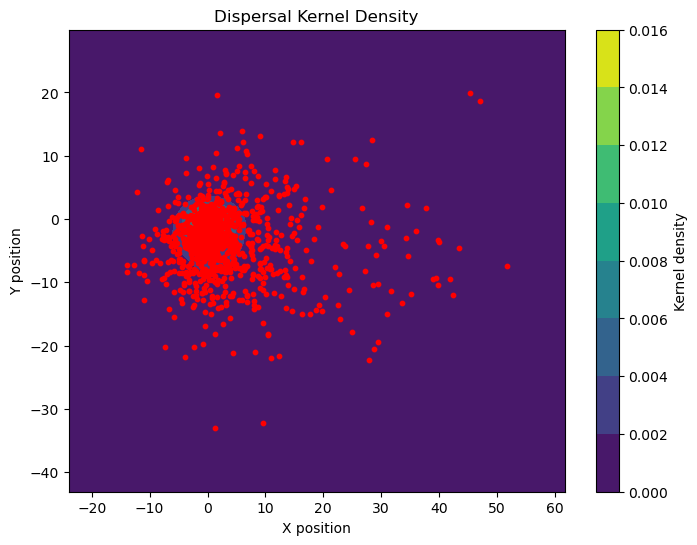

In [37]:
# Run simulations
plant_depths = [12.0]
sinking_speeds = [0.0009020192]  # must be iterable

results = {}

for r in release_heights:
    for pd_val in plant_depths:
        for ss in sinking_speeds:
            label = f"r{r}_pd{pd_val}"
            final_positions, settling_times, settled_flags = run_simulation(release_height=r, plant_depth=pd_val, sinking_speeds=ss)
            results[label] = final_positions


# Combine all final positions and label by release height
all_final_positions = []
release_labels = []
settled_flags = []

for r in release_heights:
    for pd_val in plant_depths:
        label = f"r{r}_pd{pd_val}"
        data = results.get(label)
        if data is not None and data.size > 0:
            all_final_positions.append(data)
            release_labels.extend([r] * data.shape[0])  # Tag with release height

# Stack all final positions into a single array
all_final_positions = np.vstack(all_final_positions)
release_labels = np.array(release_labels)
settled_flags = np.array(settled_flags)

# Unpack x, y positions
x = all_final_positions[:, 0]
y = all_final_positions[:, 1]

# Plot final particle positions colored by release height
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=release_labels, cmap='viridis', s=10)
cbar = plt.colorbar(scatter, label="Release Height (m)")
plt.xlabel("Eastward Displacement (m)")
plt.ylabel("Northward Displacement (m)")
plt.title("Final Particle Positions Colored by Release Height")
plt.grid(True)
plt.show()

# Dispersal Kernel density

from scipy.stats import gaussian_kde

# Remove invalid points
mask = np.isfinite(x) & np.isfinite(y)
final_x = x[mask]
final_y = y[mask]

# KDE
xy = np.vstack([final_x, final_y])
kde = gaussian_kde(xy)

# Grid for KDE evaluation
xgrid, ygrid = np.meshgrid(
    np.linspace(final_x.min() - 10, final_x.max() + 10, 100),
    np.linspace(final_y.min() - 10, final_y.max() + 10, 100)
)
positions_kde = np.vstack([xgrid.ravel(), ygrid.ravel()])
density = kde(positions_kde).reshape(xgrid.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xgrid, ygrid, density, cmap='viridis')
plt.colorbar(label="Kernel density")
plt.scatter(final_x, final_y, c='red', s=10)
plt.title("Dispersal Kernel Density")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.show()


Let's plot it better

In [39]:
import os
print(os.getcwd())

/Users/jessicafranks/grad_school/grad_thesis/thesis-python/dispersal-model/Models


In [40]:
print(f"Sample final positions:\n{final_positions[:5, :]}")


Sample final positions:
[[nan nan  0.]
 [nan nan  0.]
 [nan nan  0.]
 [nan nan  0.]
 [nan nan  0.]]
